In [3]:
import h5py
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

from pdebench.models.fno.fno import FNO1d, FNO2d, FNO3d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
problem_instance = "1D_CFD_Rand_Eta1.e-8_Zeta1.e-8_periodic_Train"
model_fn = f"/home/yppatel/mcufno/pdebench/models/trained_models/{problem_instance}_FNO.pt"
data_fn  = f"/home/yppatel/mcufno/pdebench/data_download/data/{problem_instance}.hdf5"

In [5]:
cfg = {
    "num_channels": 3, 
    "modes": 12, 
    "width": 20,
    "initial_step": 10, 
}

In [6]:
model = FNO1d(
    num_channels=cfg["num_channels"],
    width=cfg["width"],
    modes=cfg["modes"],
    initial_step=cfg["initial_step"]
).to(device)

In [7]:
checkpoint = torch.load(model_fn, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

FNO1d(
  (fc0): Linear(in_features=31, out_features=20, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [8]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.167MB


In [9]:
import math as mt

f = h5py.File(data_fn, "r")

reduced_resolution = 1
reduced_resolution_t = 1
reduced_batch = 1

_data = np.array(f['density'], dtype=np.float32)  # batch, time, x,...
idx_cfd = _data.shape

data = np.zeros([idx_cfd[0]//reduced_batch,
                      idx_cfd[2]//reduced_resolution,
                      mt.ceil(idx_cfd[1]/reduced_resolution_t),
                      3],
                    dtype=np.float32)
#density
_data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution]
## convert to [x1, ..., xd, t, v]
_data = np.transpose(_data[:, :, :], (0, 2, 1))
data[...,0] = _data   # batch, x, t, ch
# pressure
_data = np.array(f['pressure'], dtype=np.float32)  # batch, time, x,...
_data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution]
## convert to [x1, ..., xd, t, v]
_data = np.transpose(_data[:, :, :], (0, 2, 1))
data[...,1] = _data   # batch, x, t, ch
# Vx
_data = np.array(f['Vx'], dtype=np.float32)  # batch, time, x,...
_data = _data[::reduced_batch,::reduced_resolution_t,::reduced_resolution]
## convert to [x1, ..., xd, t, v]
_data = np.transpose(_data[:, :, :], (0, 2, 1))
data[...,2] = _data   # batch, x, t, ch
data = torch.tensor(data)

In [25]:
grid = np.array(f["x-coordinate"], dtype=np.float32)
grid = torch.tensor(grid[::reduced_resolution], dtype=torch.float).unsqueeze(-1)

In [43]:
quant_ft_prop = 0.25
num_quant_ft  = int(quant_ft_prop * data.shape[0])

In [26]:
# data: input tensor (first few time steps) [b, x1, ..., xd, t_init, v]
# grid: meshgrid [b, x1, ..., xd, dims]

# b: batch size
# xi: discretization elements of dim i
# t_init: time points for simulation
# v: value (i.e. for scalar/vector valued field at loc in (space, time))
sample_idx = 0
batch_size = 100

t_0 = 0
t_F = t_0 + cfg["initial_step"]
xx = data[sample_idx:sample_idx+batch_size,:,t_0:t_F,:].to(device)
yy = data[sample_idx:sample_idx+batch_size,:,t_F:t_F+1,:].to(device)

inp_shape = list(xx.shape)
inp_shape = inp_shape[:-2]
inp_shape.append(-1)
xx = xx.reshape(inp_shape)

grid = grid.unsqueeze(0).repeat(batch_size,1,1).to(device)

In [61]:
y_pred = model(xx, grid)

In [62]:
squared_error = torch.sum((yy - y_pred) ** 2)

In [63]:
def plot_result(res, ax):
    plot_Y = res.cpu().detach().numpy()
    for i in range(3):
        plot_Y[:,:,i] -= np.min(plot_Y[:,:,i])
        plot_Y[:,:,i] /= np.max(plot_Y[:,:,i])
    ax.imshow(plot_Y, aspect=1/100)

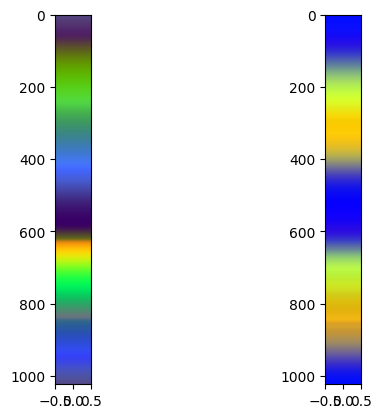

In [64]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
plot_result(yy[0], axs[0])
plot_result(y_pred[0], axs[1])